In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(ggthemes)

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”
Attaching SeuratObject

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
myeloid = readRDS("data/myeloid.annotate.rds")

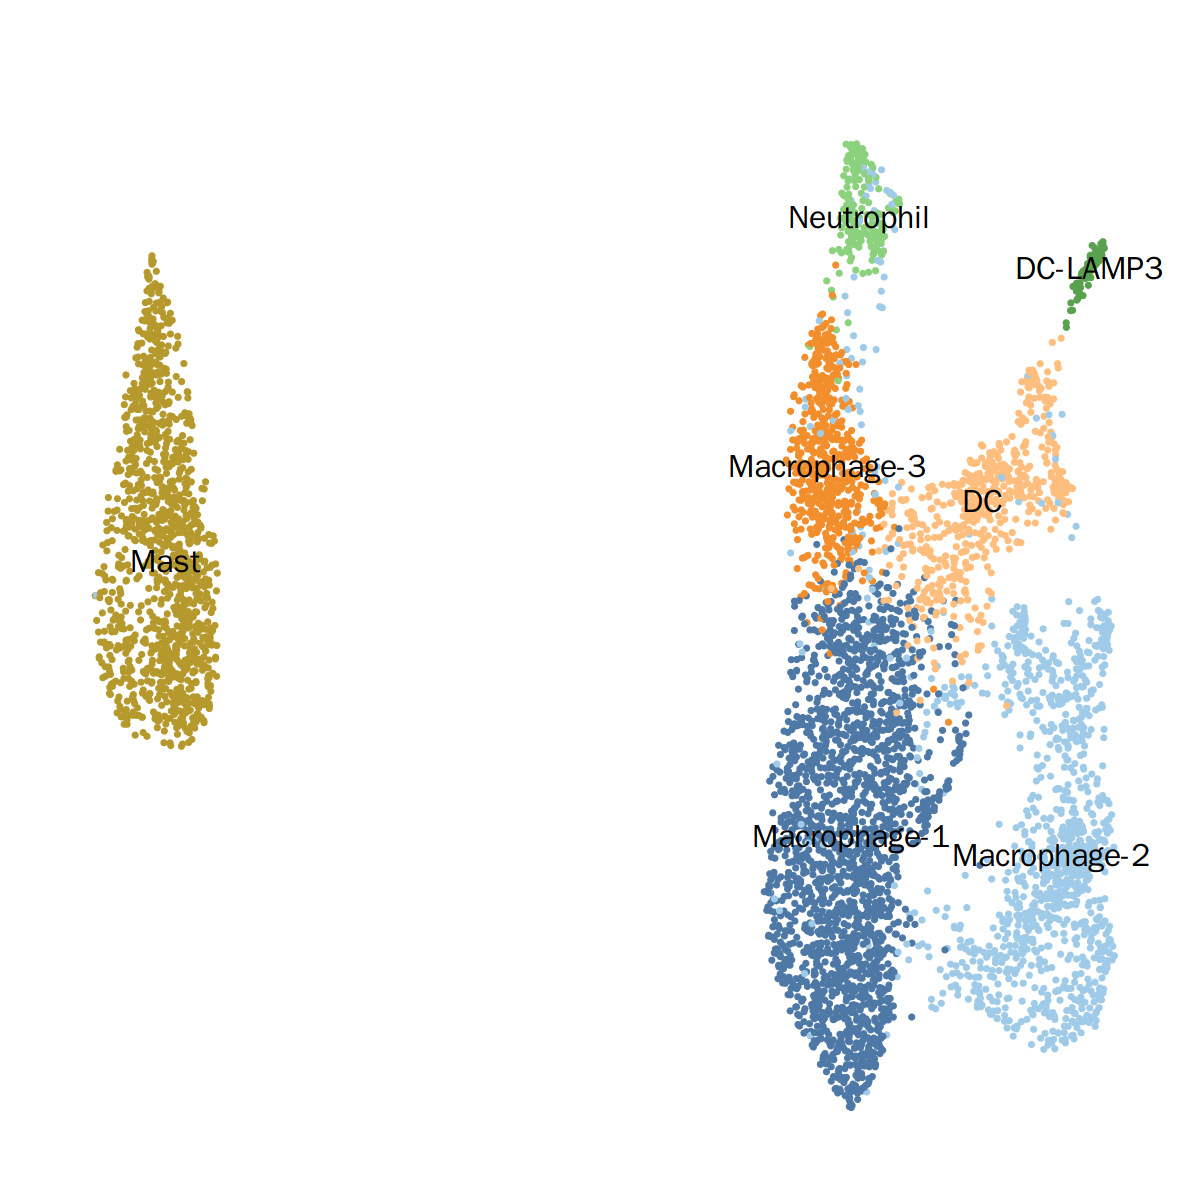

In [3]:
options(repr.plot.height =6, repr.plot.width = 6, repr.plot.res=200)

DimPlot(myeloid, group.by="cell.type2",  label = T, raster=F) + NoAxes()  +  scale_colour_tableau("Tableau 20") +NoLegend() + ggtitle("")

In [4]:
plot_cluster_percent_bar <- function(object, x, color.by, color=FALSE) {
    require(ggplot2)
    require(ggthemes)
    batch_numbef <- aggregate(object@meta.data[color.by][,1], by=list(object@meta.data[color.by][,1], object@meta.data[x][,1]), FUN = length)
    names(batch_numbef) = c("n1", "n2", "num")
    
    batch2 <- aggregate(object@meta.data[x][,1], by=list(object@meta.data[x][,1]), FUN = length)
    
    percent = c()
    for (i in rownames(batch_numbef)) {
        k = batch_numbef[i,]

        percent = c(percent, 100*k$num/batch2$x[batch2$Group.1 == as.character(k$n2)])
    }

    batch_numbef["percent"] = percent
    batch_numbef$n1 = factor(batch_numbef$n1)
    if (identical(color, FALSE)) {
        plot = ggplot(data=batch_numbef, aes(x=as.factor(n2), y=percent, fill=n1)) + geom_col() +  scale_fill_tableau("Tableau 20") + labs(x = x, fill =color.by) 
    } else {
        plot = ggplot(data=batch_numbef, aes(x=as.factor(n2), y=percent, fill=n1)) + geom_col() +  scale_fill_manual(values=color) + labs(x = x, fill =color.by)
          
    }

    return(plot)
}

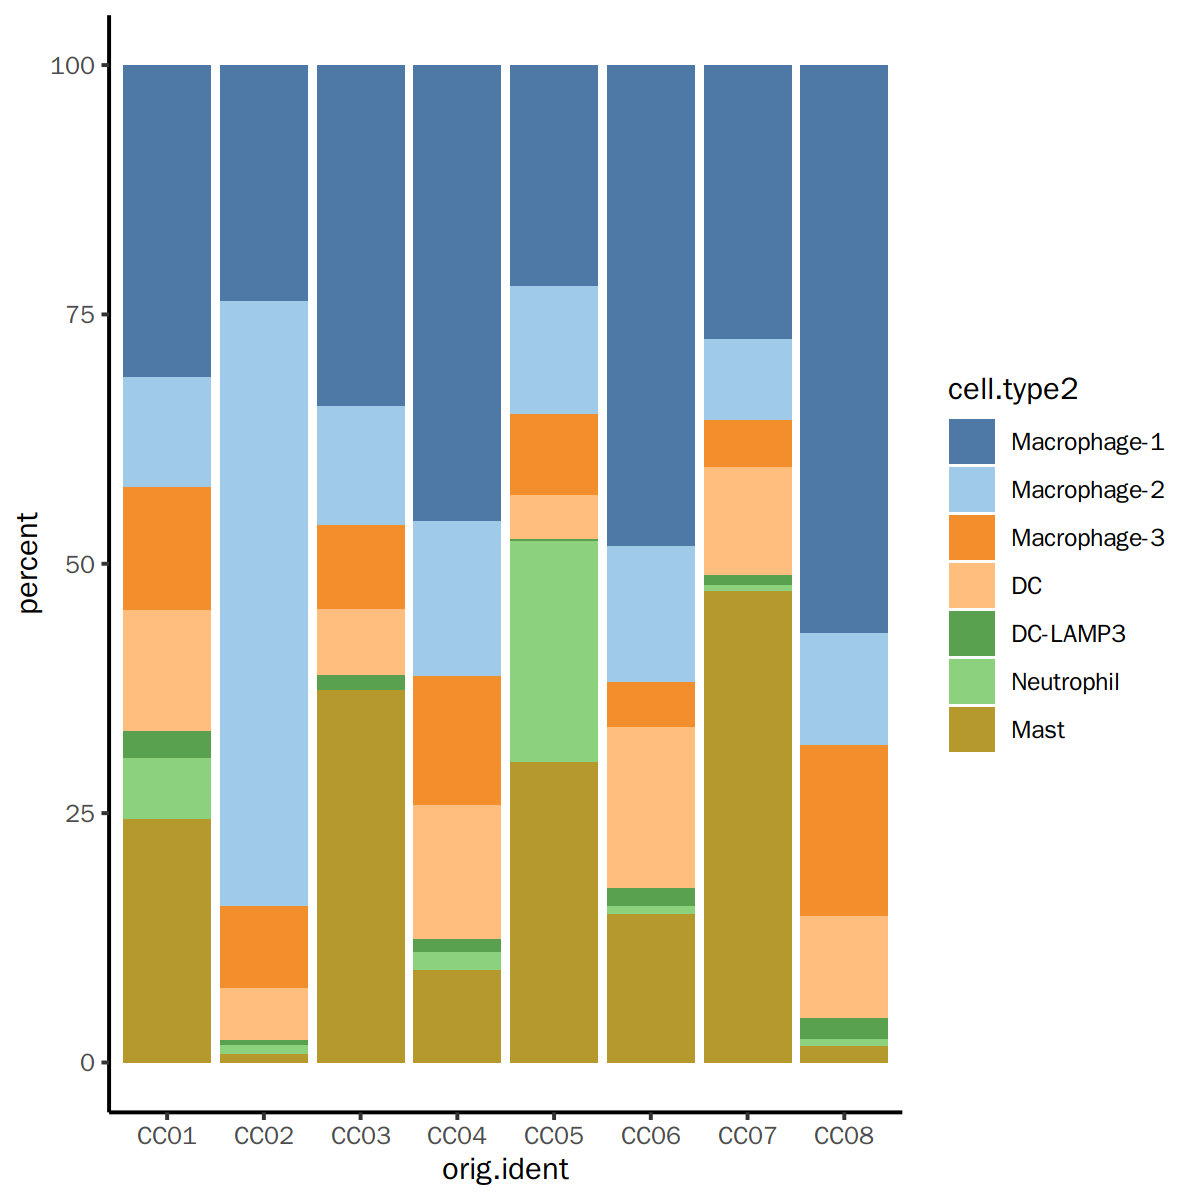

In [5]:
options(repr.plot.height =6, repr.plot.width = 6, repr.plot.res=200)
p = plot_cluster_percent_bar(myeloid, color.by="cell.type2", x="orig.ident") 
p + theme_classic()

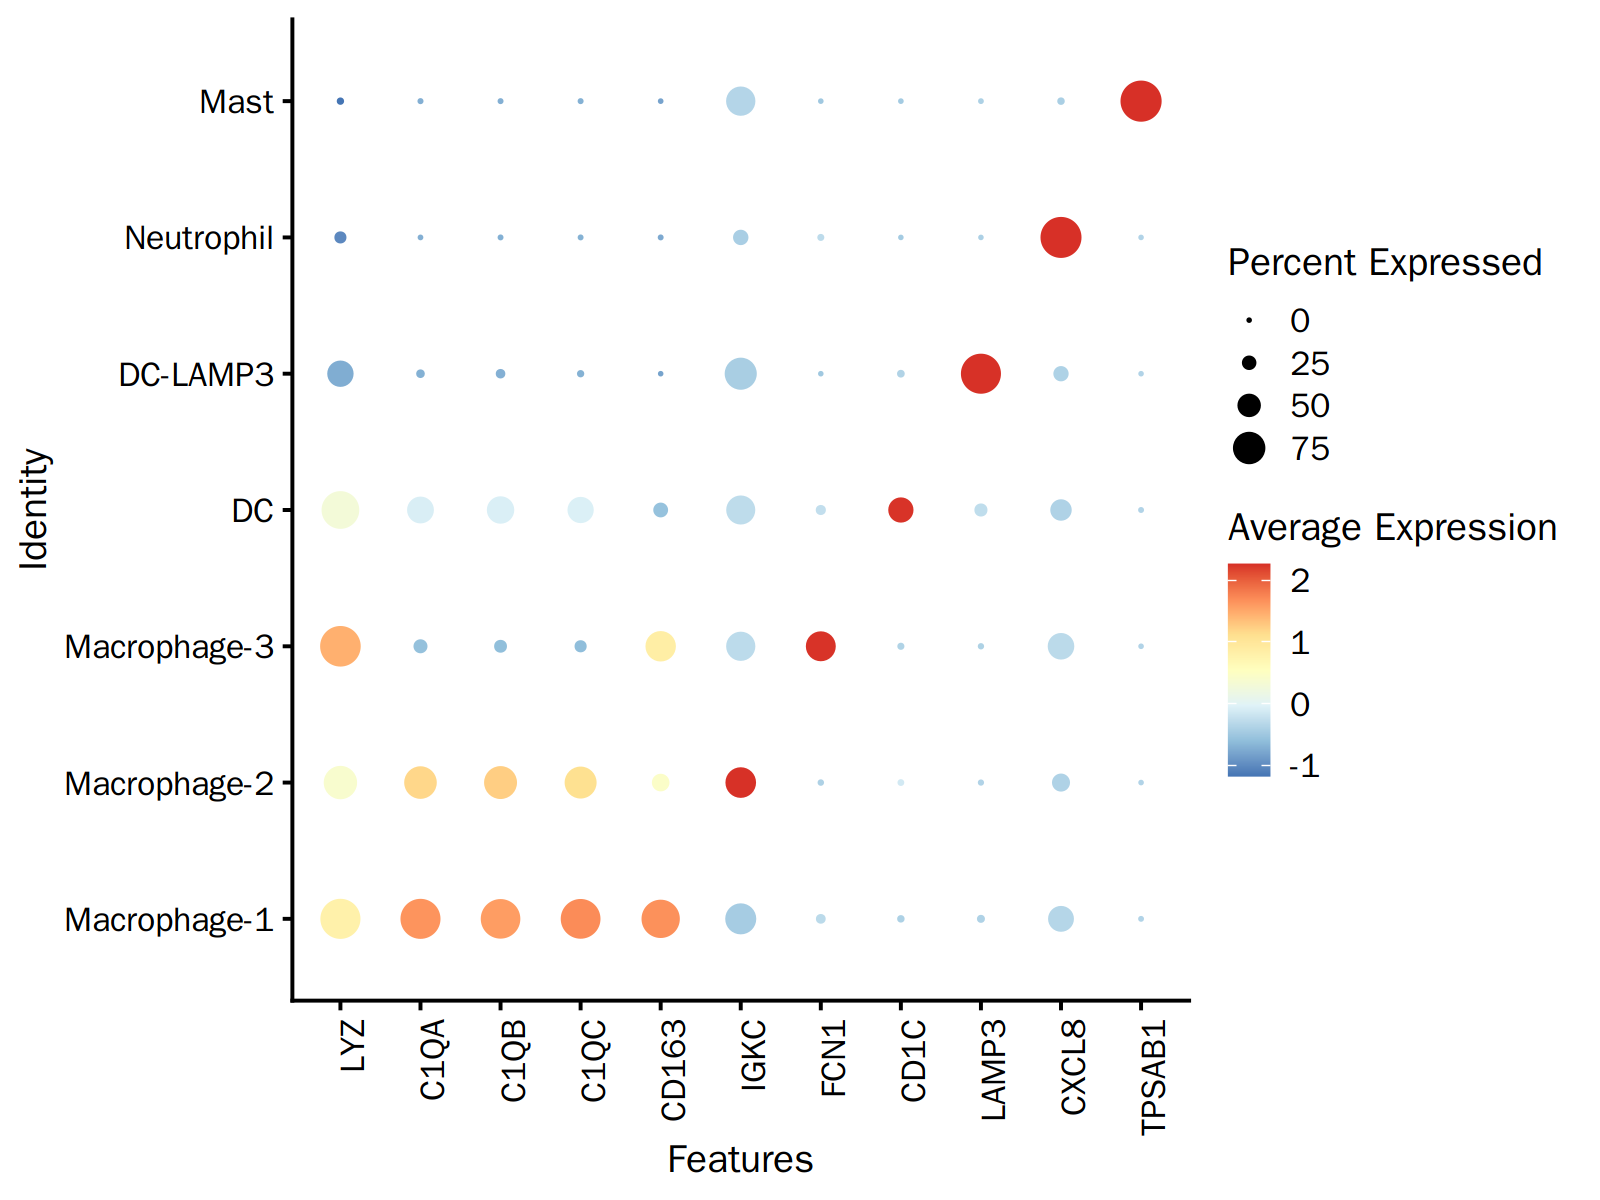

In [6]:
options(repr.plot.height =6, repr.plot.width = 8, repr.plot.res=200)

DotPlot(myeloid, group.by = "cell.type2", features=c(
    "LYZ","C1QA", "C1QB","C1QC", "CD163", "IGKC",  "FCN1","CD1C", "LAMP3", "CXCL8", "TPSAB1"), cols="RdYlBu") + 
theme(axis.text.x = element_text(angle = 90, hjust=1))

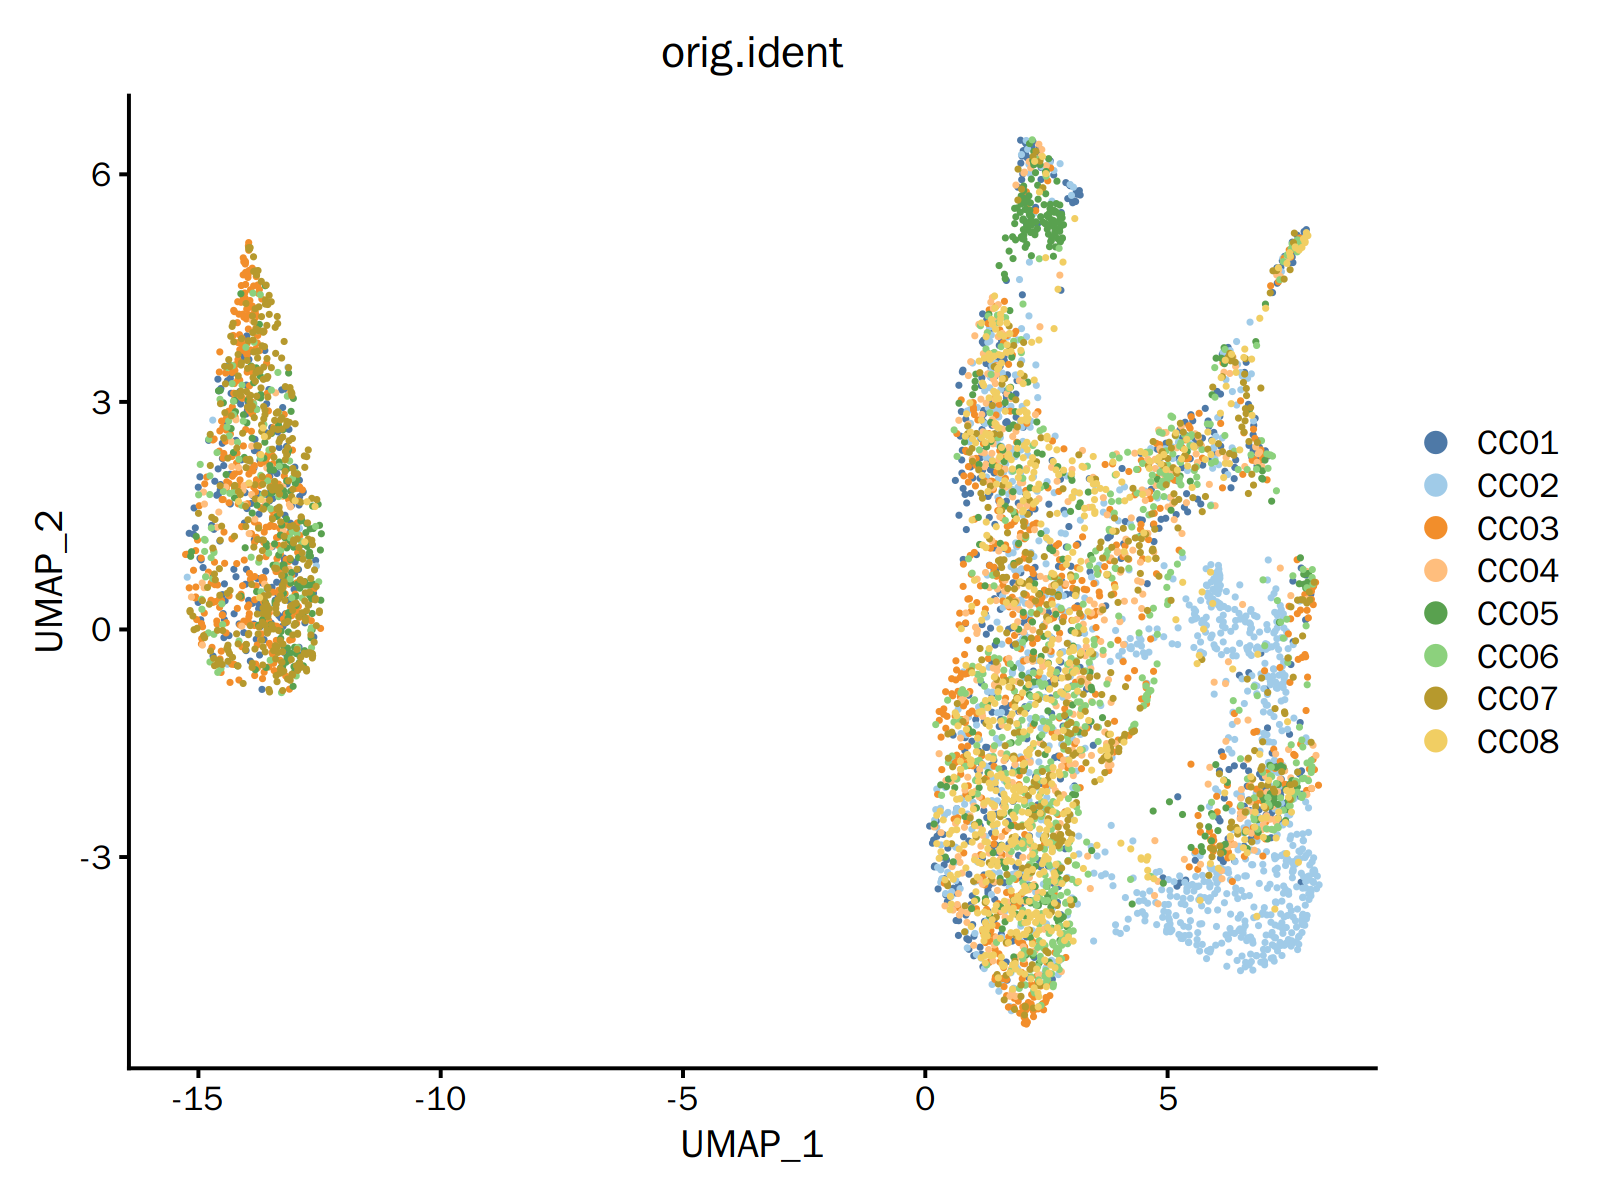

In [7]:
DimPlot(myeloid, group.by="orig.ident") +  scale_colour_tableau("Tableau 20") 

In [8]:
cal_tam_mdsc_marcophage_score <- function(object) {
    require(Seurat)
    require(dplyr)

    # genesets from Landscape and Dynamics of Single Immune Cells in Hepatocellular Carcinoma (zhang et.al 2019)
    tam_like_genesets = c( "CD163", "SIGLEC1", "C1QA", "SLC40A1", "GPNMB")
    mdsc_like_genesets = c("THBS1", "S100A8", "S100A9")
    
    r = AddModuleScore(object, features=list(tam_like_genesets, mdsc_like_genesets), name="mac")
    
    r@meta.data = rename(r@meta.data, tam_like = mac1)
    r@meta.data = rename(r@meta.data, mdsc_like = mac2)
    
    return(r)
    }

In [9]:
myeloid = cal_tam_mdsc_marcophage_score(myeloid)

Loading required package: RColorBrewer

Warning message:
“package ‘RColorBrewer’ was built under R version 4.0.5”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



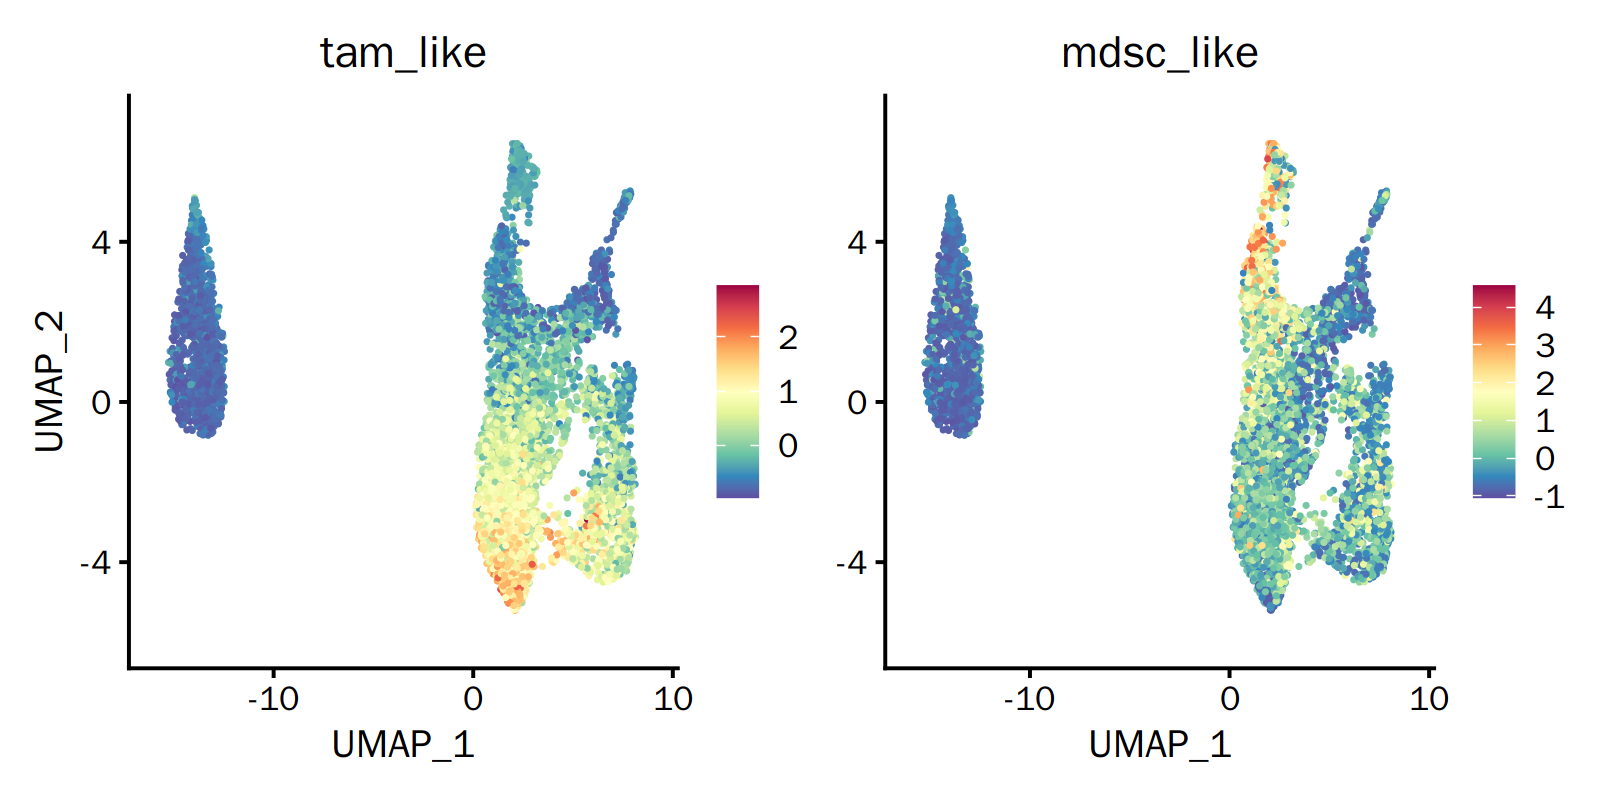

In [10]:
require("RColorBrewer")

options(repr.plot.height =4, repr.plot.width = 8, repr.plot.res=200)
p1 = FeaturePlot(myeloid, features = c("tam_like"))+scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "Spectral"))) 
p2 = FeaturePlot(myeloid, features = c("mdsc_like"))+scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "Spectral"))) + theme(axis.title.y = element_blank())
p1|p2

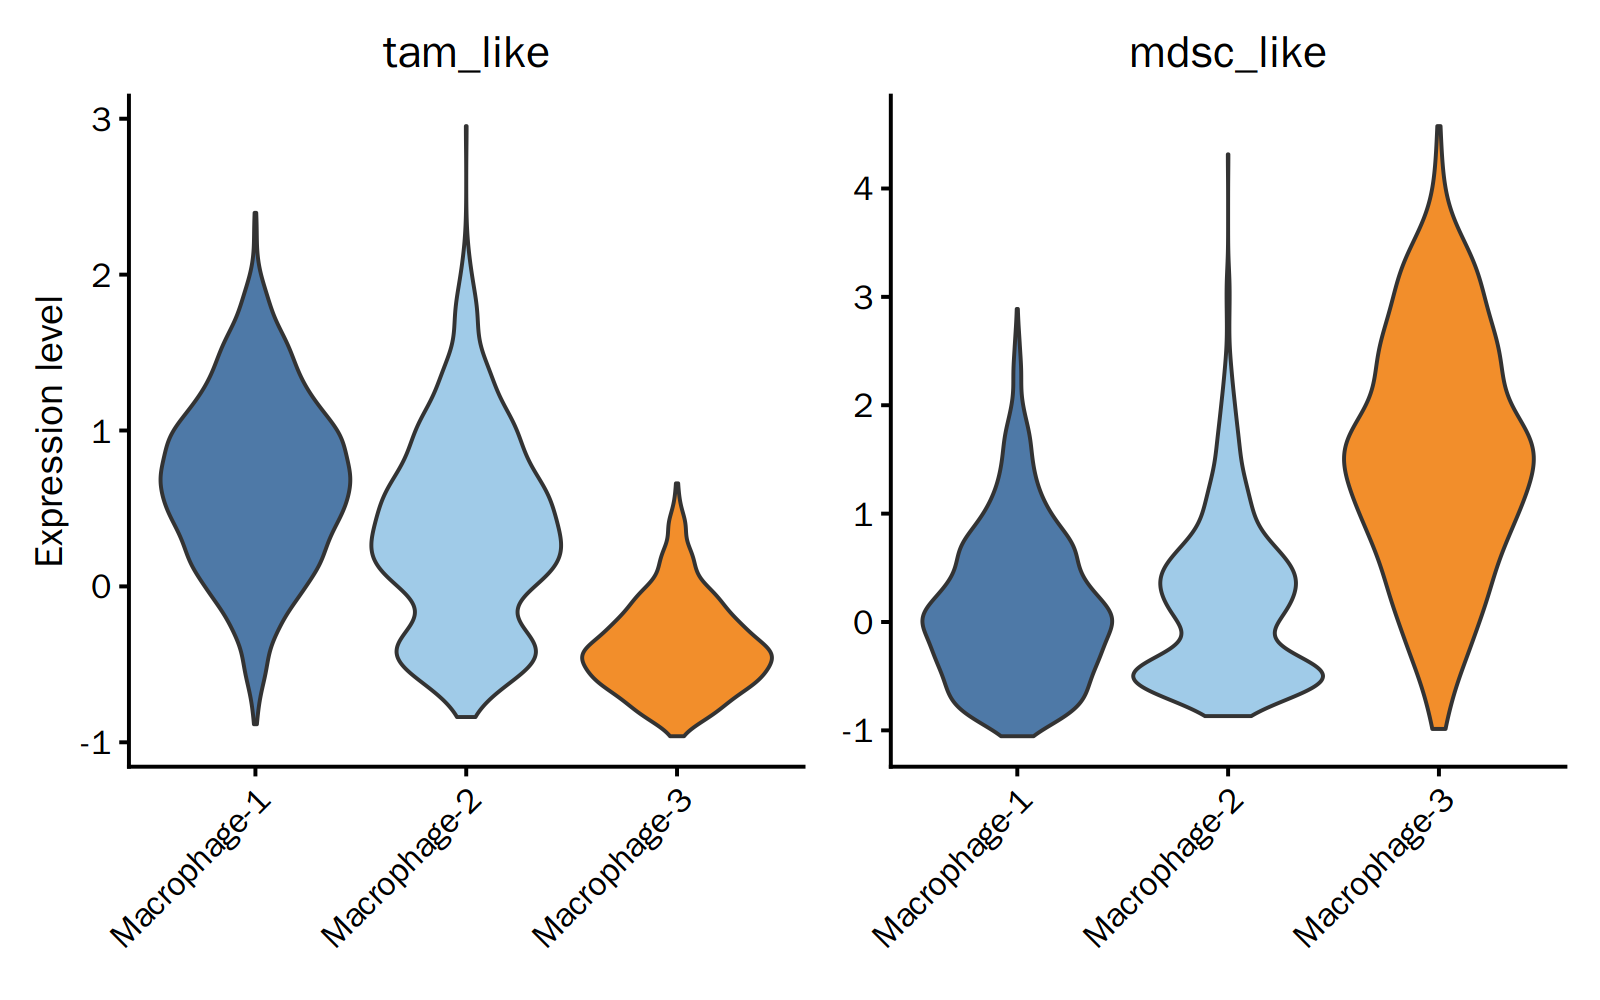

In [11]:
options(repr.plot.height =5, repr.plot.width = 8, repr.plot.res=200)
macro = subset(myeloid, subset= cell.type2 %in% c("Macrophage-1", "Macrophage-2","Macrophage-3"))
p3 = VlnPlot(macro, features = c("tam_like"), group.by="cell.type2", pt.size=0) + NoLegend()+  scale_fill_tableau("Tableau 20") + ylab("Expression level") + theme(axis.title.x = element_blank())
#ggsave("figures/myloid_tam_like_vlnplot.pdf", width=5.5, height=6)
p4 = VlnPlot(macro, features = c("mdsc_like"), group.by="cell.type2", pt.size=0) + NoLegend()+  scale_fill_tableau("Tableau 20") + theme(axis.title.x = element_blank())
p3|p4 

In [15]:
myeloid_multiple_gene_lists <- read.table("data/myeloid.sigture_gene.csv", header = T, sep = ",")
x_newdata <- data.frame(myeloid_multiple_gene_lists)

#merge two gene of interests and prepare annotations
anno_data <- x_newdata
anno_data_unique <- anno_data[!duplicated(anno_data$gene), ]
anno_data_unique <- data.frame(anno_data_unique)
avail_genes <- intersect(x = anno_data_unique$gene, y = rownames(myeloid))
anno_data_unique = anno_data_unique[anno_data_unique$gene %in% avail_genes,]
pheatmap_names <- as.data.frame(anno_data_unique$cluster)
rownames(pheatmap_names) <- anno_data_unique$gene

#pull only genes present within seurat obj


#USe seurat dotplot to generate scaled averaged expression data
dplot <- DotPlot(object = myeloid,group.by="cell.type2",  features = unique(avail_genes))

#extract matrix and spread, and prepare 
ddata <- as.data.frame(dplot[["data"]])
df <- tidyr::spread(ddata[, c(3,4,5)], id, avg.exp.scaled)
rownames(df) <- df[, 1]
df <- df[, -1]
mat <- as.matrix(df)
mat[is.na(mat)] <- 0

#Change name 
names(pheatmap_names) = c("Gene_List")
pheatmap_names = pheatmap_names[]

In [16]:
order <- c("Macrophage-1","Macrophage-2","Macrophage-3", "DC", "DC-LAMP3","Mast", "Neutrophil")
mat.ordered <- mat[,order]
cols <- colorRampPalette(brewer.pal(12, "Paired"))
pheatmap_color <- pheatmap_names
mycolors <- cols(length(unique(pheatmap_color$Gene_List)))
names(mycolors) <- unique(pheatmap_color$Gene_List)
mycolors <- list(Gene_List = mycolors)

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




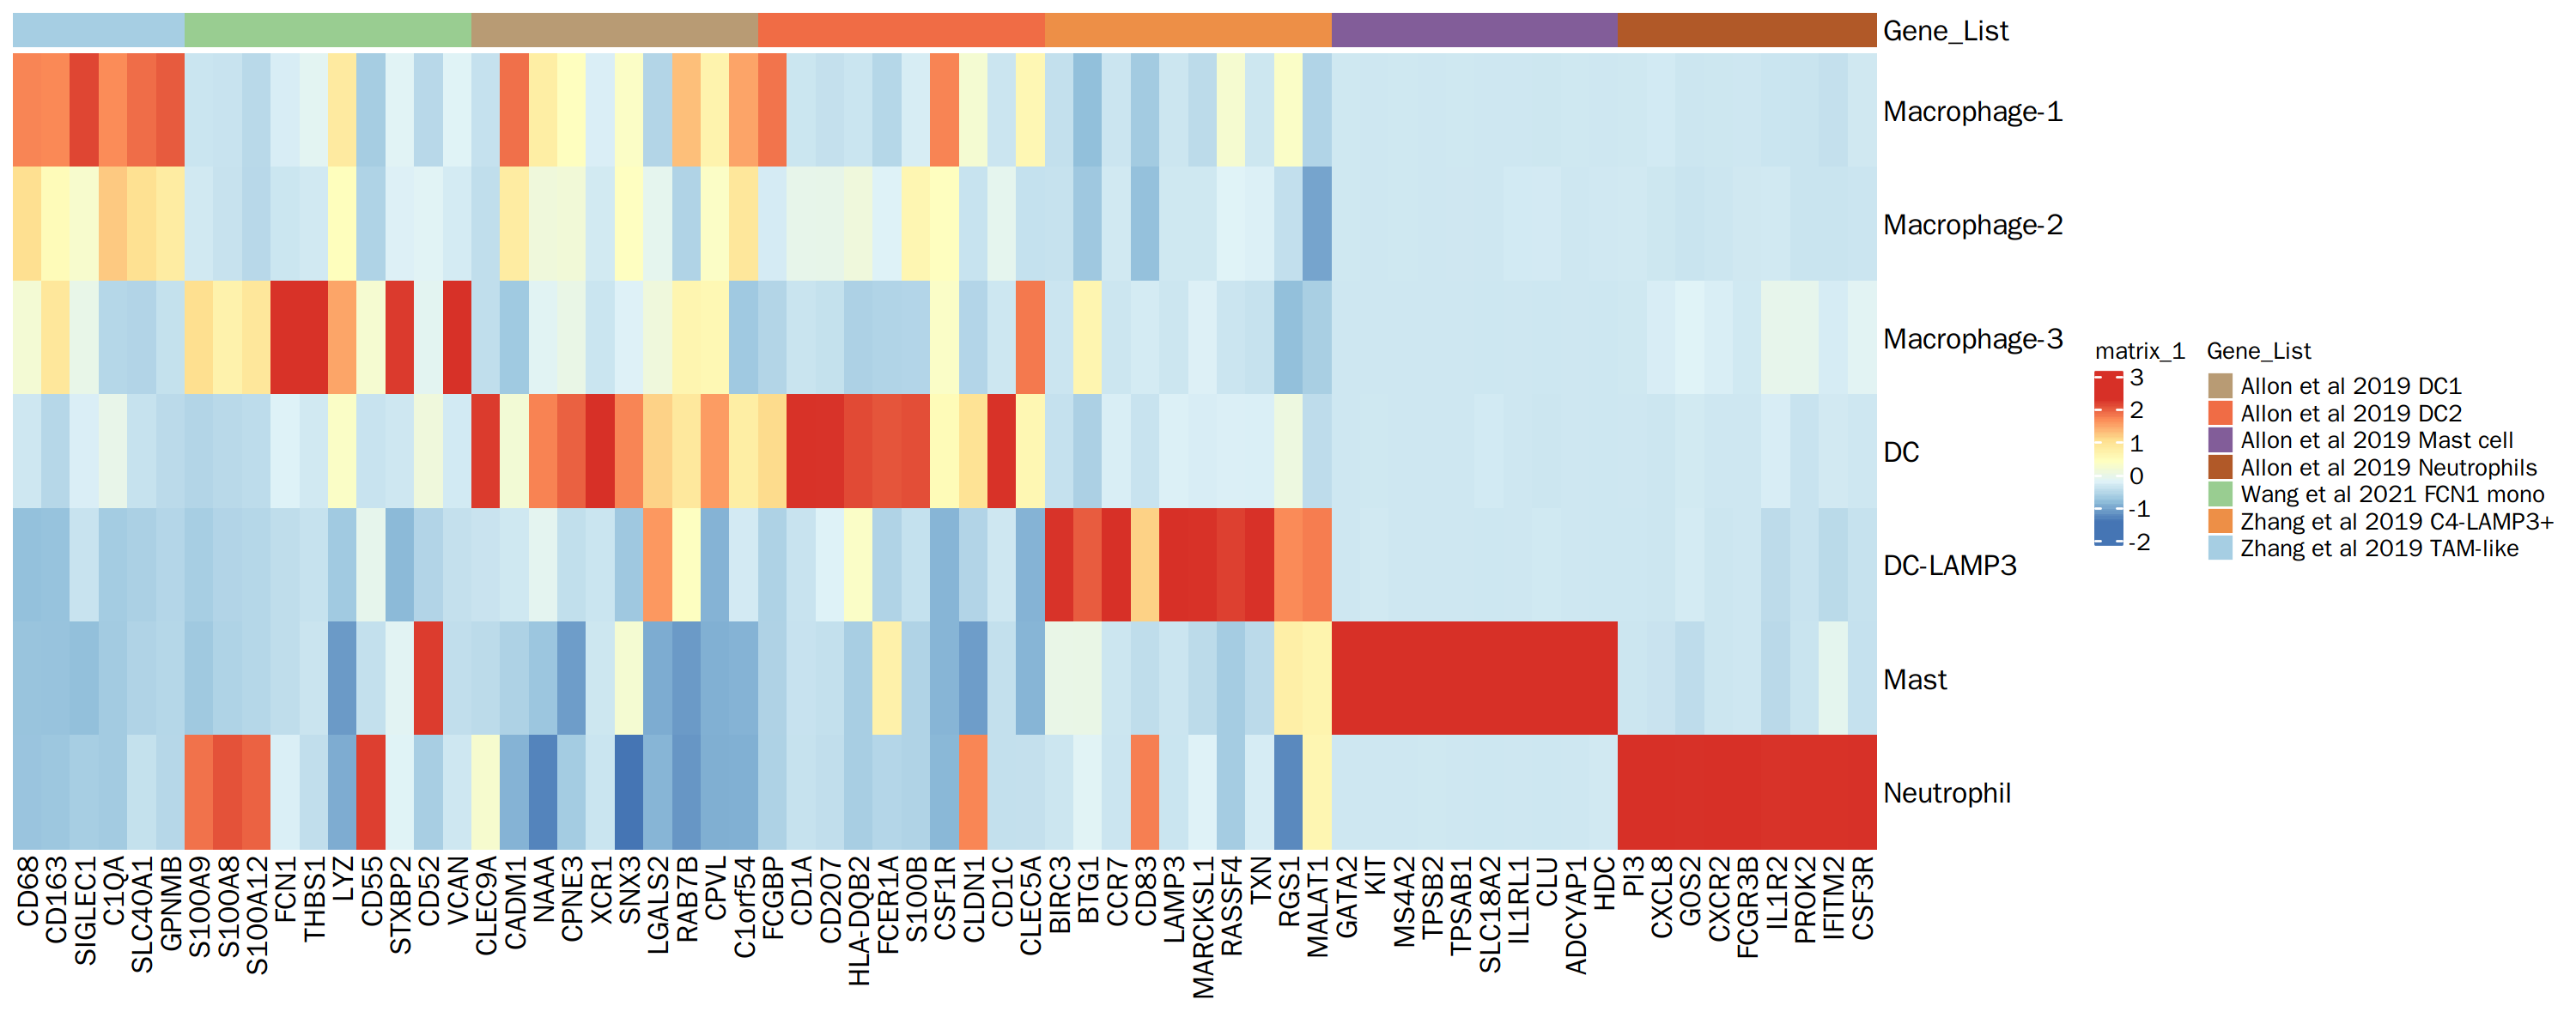

In [17]:
library(ComplexHeatmap)
options(repr.plot.height =6, repr.plot.width = 15, repr.plot.res=200)
ha = HeatmapAnnotation(Gene_List=pheatmap_color$Gene_List, col = mycolors)
p = Heatmap(t(mat.ordered),  cluster_rows = F , cluster_columns = F, top_annotation = ha, col = colorRampPalette(rev(brewer.pal(n = 7, name =
                                                          "RdYlBu")))(100))
print(p)


In [18]:
lymph = readRDS("data/lymph.annotate.rds")
lymph

An object of class Seurat 
30397 features across 42951 samples within 2 assays 
Active assay: RNA (27397 features, 0 variable features)
 1 other assay present: integrated
 3 dimensional reductions calculated: pca, umap, tsne

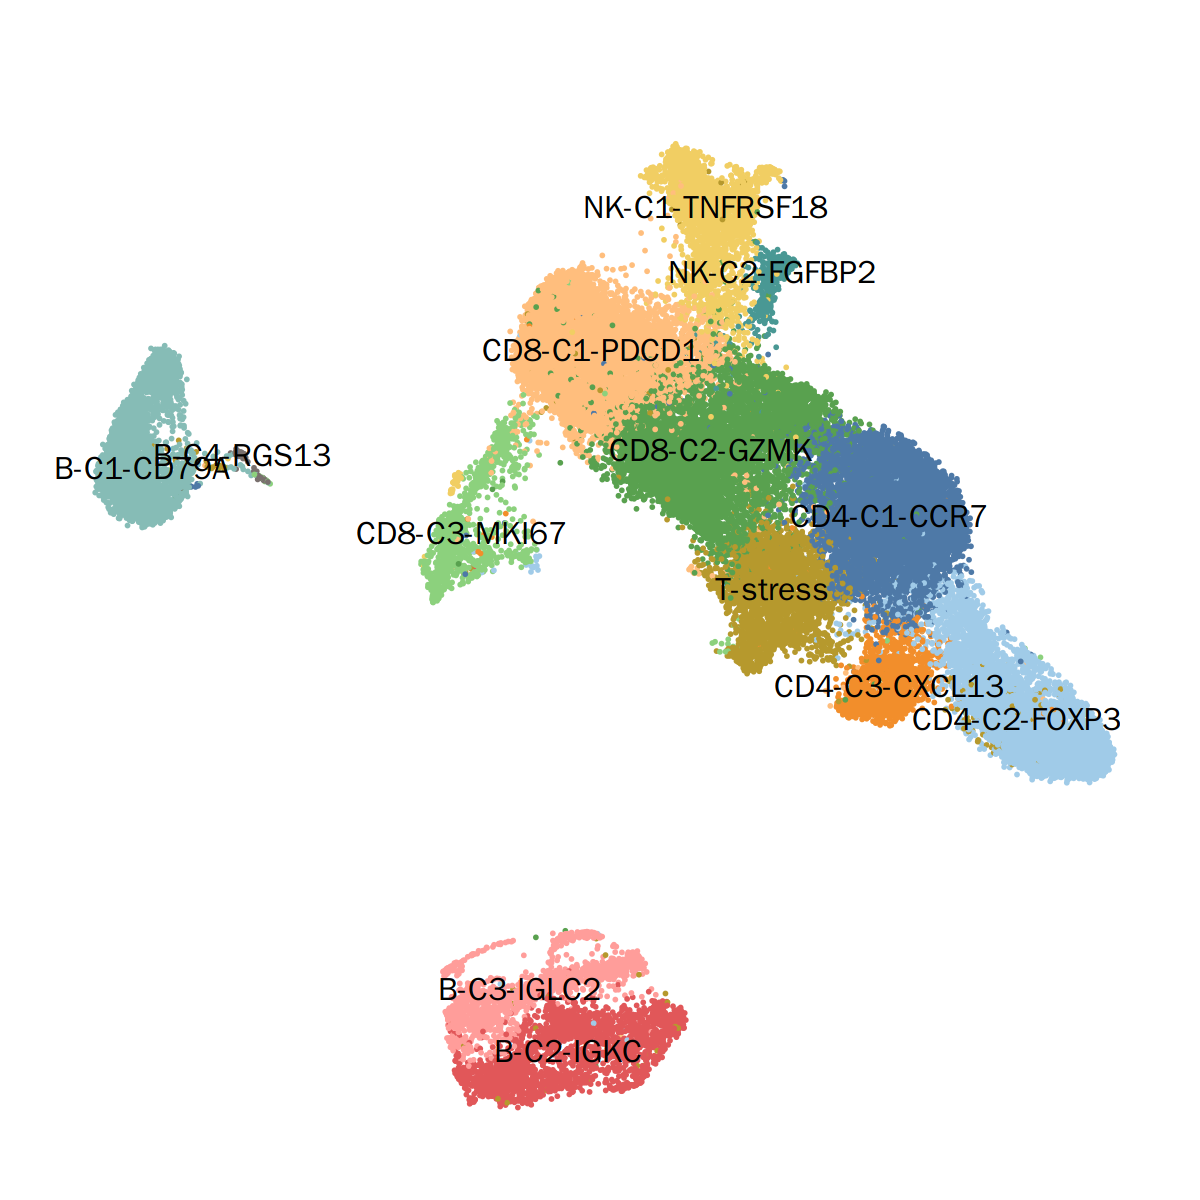

In [20]:
options(repr.plot.height =6, repr.plot.width = 6, repr.plot.res=200)
DimPlot(lymph,group.by="cell.type2",  label = T, raster=F) + NoAxes()  +  scale_colour_tableau("Tableau 20") +NoLegend() + ggtitle("")

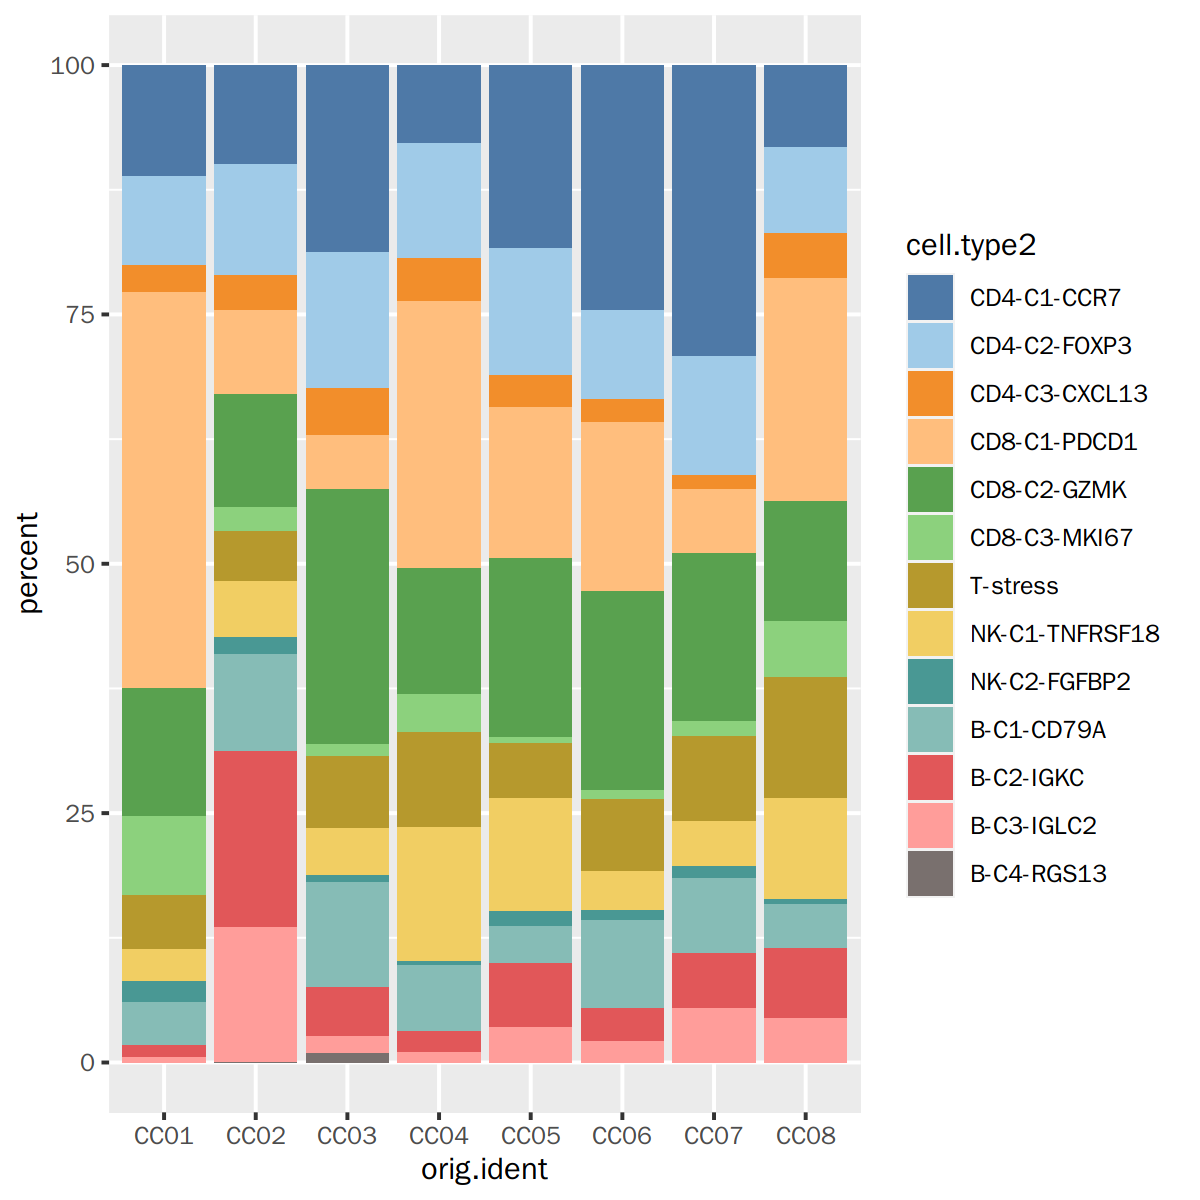

In [21]:
plot_cluster_percent_bar(lymph, color.by="cell.type2", x="orig.ident") 

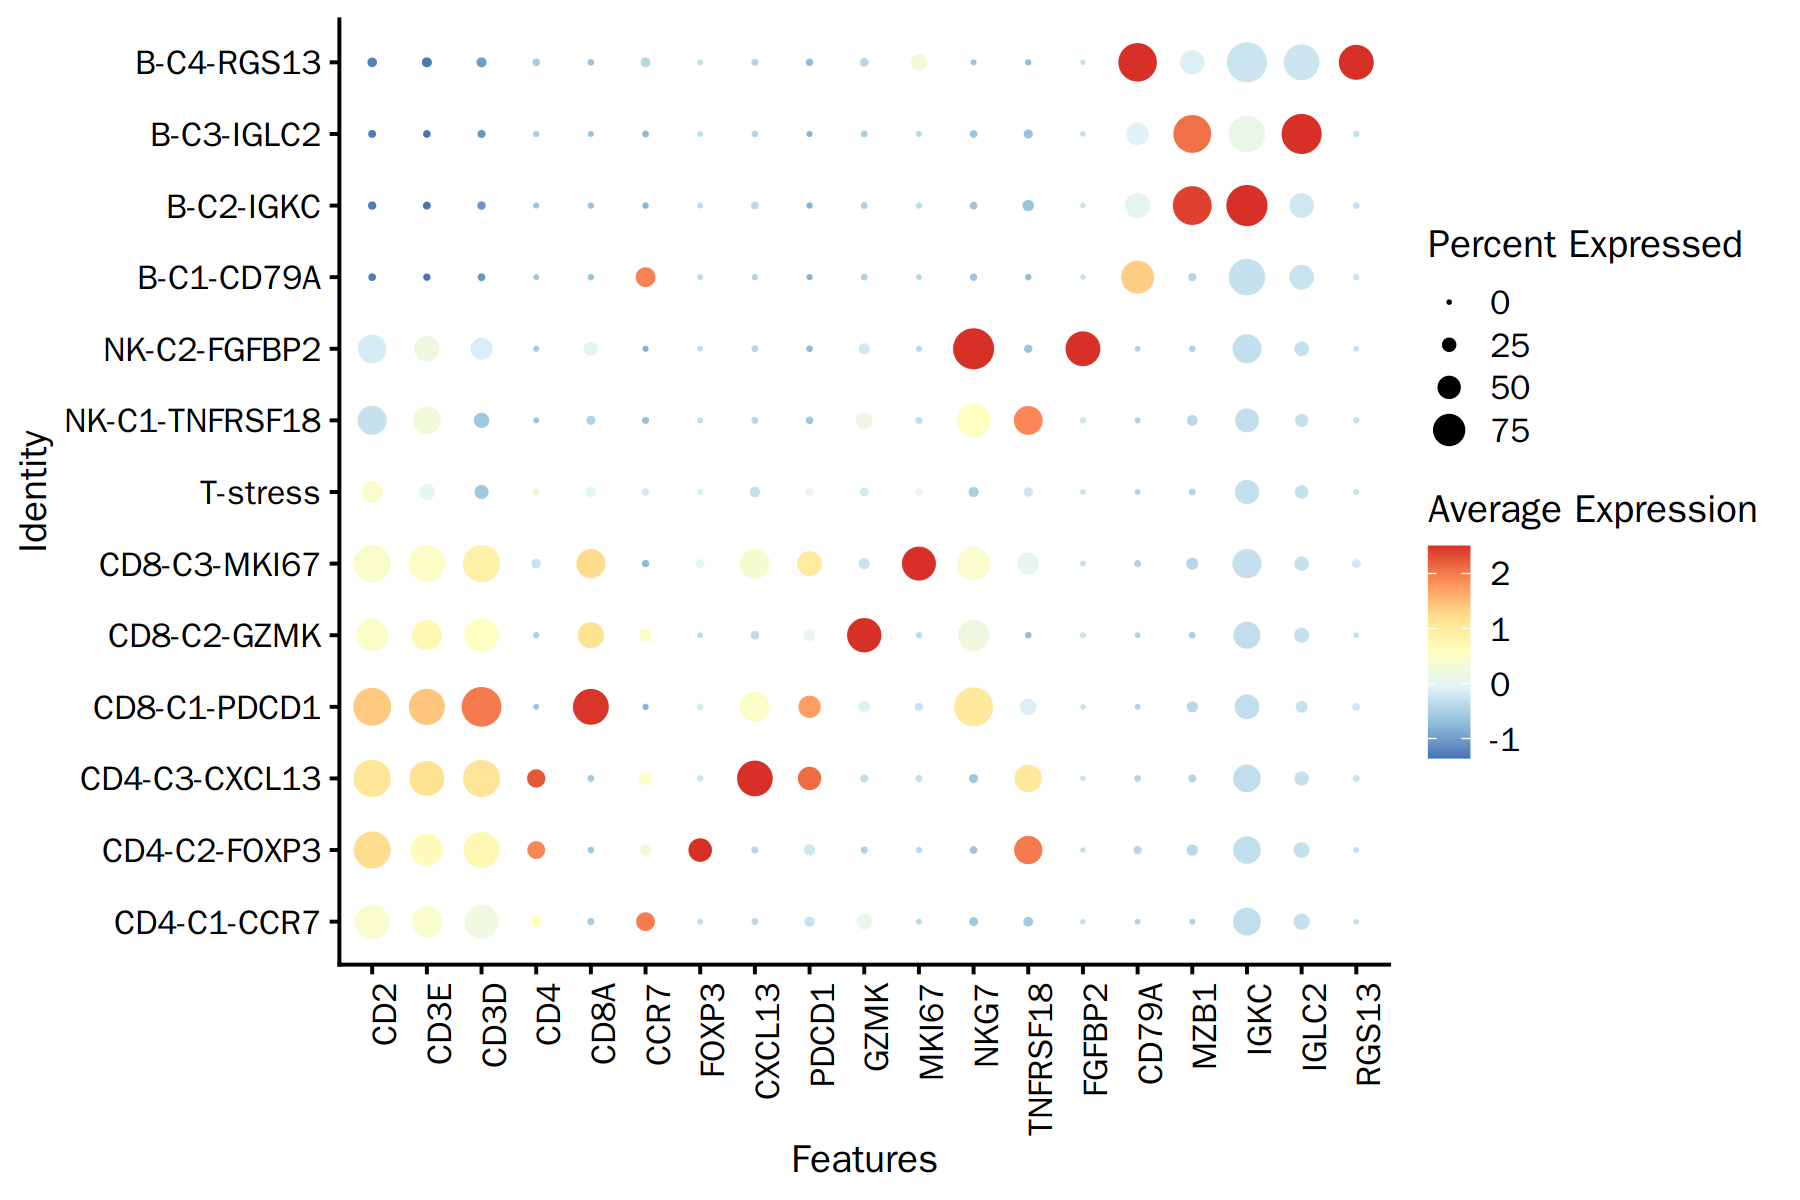

In [22]:
options(repr.plot.height =6, repr.plot.width = 9, repr.plot.res=200)

DotPlot(lymph, group.by = "cell.type2", features=c(
    "CD2","CD3E","CD3D", "CD4", "CD8A", "CCR7", "FOXP3", "CXCL13", "PDCD1", "GZMK", "MKI67", "NKG7",
    "TNFRSF18", "FGFBP2", "CD79A", "MZB1", "IGKC", "IGLC2", "RGS13"), cols="RdYlBu") + 
theme(axis.text.x = element_text(angle = 90, hjust=1))